# US Based Ecommerce Company Sales Performance

## About Dataset

* A US Based Ecommerce Sales Company wants us to create a sales dashboard showing information of YTD sales and various others to generate insights for improving business performance.

* The given dataset contains information on 113 thousand sales records based on product categories, customer segments, cities, and states of customer residence, and various many others.

* Dataset Source : https://drive.google.com/drive/folders/1vnI_RR3iDTLb6dH_tluCSsPqWcXPRHKR. This dataset was originally from a tutorial of Power BI tutorial, but since i haven't learn that (by the time i started this project), i will try to recreate the results in using the tools that i am familiar with that is Python, SQL, and Tableau.

## Problem Statement

A US Based Ecommerce Sales Company wants us to create a Sales Dashboard showing information of YTD Sales and generate insights for below scenarios :

* Create a KPI Banner showing YTD Sales, YTD Profit, YTD Quantity sold, YTD Profit Margin
* Find Year on Year Growth for each KPI and show a YTD sparkline for each measure in the KPI to understand the monthly trend for each fact
* Find YTD Sales, YoY Sales growth for different customer category. Add a trend icon for each category
* Find YTD Sales performance by each State
* Top 5 and Bottom 5 Procucts by Sales
* YTD Sales by Region to know the best and worst performing region all over country
* YTD Sales by Shipping Type to get the best shipping type percentage

This python code is only for quick data understanding, most of the work (calculation and dimension/measure creation) is done directly in Tableau. While for the SQL code i used it to answer questions as well (to sharpen my SQL skills further) and ensure that the calculations in Tableau are accurate.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.23.5
pandas version :  1.5.3
seaborn version :  0.12.2


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Latihan Sendiri (Projects)/US Based Ecommerce Company Sales Performance/ecommerce_data.csv', encoding='latin-1')

There are some problem in reading the csv file. I can't seem to open it normally since it will display this error :

* UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe0 in position 14101: invalid continuation byte

So i would need to change the encoding to other type and in this case i use encoding='latin-1'

The same issue also occurred during data import in PostgreSQL, so the solution is to follow the same encoding format, which is LATIN1, and adjust some import options such as removing quotes and escape characters because there are some values in the product_name column that are causing errors.

In [4]:
# #This code is optional
# #Only used for machine learning purpose and cleaning values of product_name

# characters_to_remove = ['!', '@', '#', '$', '%', '^', '"', ',', '.', '/', '(',')', '', ' ']
# df['product_name'] = df['product_name'].apply(lambda x: ''.join(char for char in x if char not in characters_to_remove) if isinstance(x, str) else x)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113270 entries, 0 to 113269
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   customer_id                  113270 non-null  object 
 1   customer_first_name          113270 non-null  object 
 2   customer_last_name           113270 non-null  object 
 3   category_name                113270 non-null  object 
 4   product_name                 113270 non-null  object 
 5   customer_segment             113270 non-null  object 
 6   customer_city                113270 non-null  object 
 7   customer_state               113270 non-null  object 
 8   customer_country             113270 non-null  object 
 9   customer_region              113270 non-null  object 
 10  delivery_status              113270 non-null  object 
 11  order_date                   113270 non-null  object 
 12  order_id                     113270 non-null  object 
 13 

In [6]:
df.isna().sum()

customer_id                    0
customer_first_name            0
customer_last_name             0
category_name                  0
product_name                   0
customer_segment               0
customer_city                  0
customer_state                 0
customer_country               0
customer_region                0
delivery_status                0
order_date                     0
order_id                       0
ship_date                      0
shipping_type                  0
days_for_shipment_scheduled    0
days_for_shipment_real         0
order_item_discount            0
sales_per_order                0
order_quantity                 0
profit_per_order               0
dtype: int64

In [7]:
df.duplicated().sum()

0

There is no missing or duplicated value in this dataset

In [8]:
df.head()

,customer_id,customer_first_name,customer_last_name,category_name,product_name,customer_segment,customer_city,customer_state,customer_country,customer_region,...,order_date,order_id,ship_date,shipping_type,days_for_shipment_scheduled,days_for_shipment_real,order_item_discount,sales_per_order,order_quantity,profit_per_order
0,C_ID_45866,Mary,Fuller,Office Supplies,Xerox 1913,Corporate,New Rochelle,New York,United States,East,...,11-05-2022,O_ID_3001072,11-07-2022,Second Class,2,2,35.0,500.0,5,223.199997
1,C_ID_44932,Alan,Edelman,Office Supplies,#6 3/4 Gummed Flap White Envelopes,Corporate,Houston,Texas,United States,Central,...,20-06-2022,O_ID_3009170,23-06-2022,Second Class,2,3,85.0,500.0,5,199.199997
2,C_ID_70880,Mary,Gayman,Office Supplies,Belkin 8 Outlet Surge Protector,Consumer,Louisville,Kentucky,United States,South,...,25-06-2022,O_ID_3047567,30-06-2022,Standard Class,4,5,75.0,44.0,5,195.500000
3,C_ID_33157,Raymond,Eason,Office Supplies,GBC VeloBinder Manual Binding System,Corporate,Chicago,Illinois,United States,Central,...,10-06-2022,O_ID_3060575,10-10-2022,Second Class,2,4,60.0,254.0,1,220.000000
4,C_ID_58303,Mary,Gonzalez,Furniture,Eldon Pizzaz Desk Accessories,Home Office,Philadelphia,Pennsylvania,United States,East,...,02-05-2022,O_ID_3064311,08-01-2022,First Class,1,2,125.0,500.0,1,97.500000


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
days_for_shipment_scheduled,113270.0,2.931209,1.375914,0.00,2.000000,4.000000,4.000000,4.00000
days_for_shipment_real,113270.0,3.464006,1.632198,0.00,2.000000,3.000000,5.000000,6.00000
order_item_discount,113270.0,21.105465,22.959207,0.00,5.500000,14.400000,30.000000,500.00000
sales_per_order,113270.0,204.499537,141.443090,9.99,119.980003,199.919998,299.950012,1999.98999
order_quantity,113270.0,1.967564,1.355254,1.00,1.000000,1.000000,3.000000,5.00000
profit_per_order,113270.0,23.069382,105.288561,-3366.00,7.200000,32.029999,65.570000,2600.00000


In [10]:
df.describe(exclude=['int64', 'float64']).transpose()

,count,unique,top,freq
customer_id,113270,42047,C_ID_65824,5
customer_first_name,113270,757,Mary,40436
customer_last_name,113270,586,Miller,1403
category_name,113270,3,Office Supplies,68111
product_name,113270,1849,Staples,556
customer_segment,113270,3,Consumer,58714
customer_city,113270,531,New York City,10346
customer_state,113270,49,California,22679
customer_country,113270,1,United States,113270
customer_region,113270,4,West,36295


There are several interesting things and pieces of information that we can gather even only up until here, some of them are :

1. order_id is the unique identifier for this data, we will utilize that for counting rows in Tableau later and for primary key in SQL table creation
2. customer_id maybe can have the same value even if the individuals placing the orders are different (as seen from the different count in unique values)
3. There are transactions that have minus profit, probably due to high shipping cost or other expenses
4. The max order_date is 04-03-2021	but the max ship_date is 30-09-2022, probably happened in products with low or minus profits due to delay in shipping the goods to the customer. (could be useful depends on the business problems/context that we want to solve)
5. At the first glance, since this is US Based data so customer_country will only display 1 value that is united states, usually we will just drop that column in Python and SQL but in Tableau we need that for hierarchy of country-state-city

And other information that will be examined during a more in-depth analysis before jumping to vusialization.

### More Data Understanding

In [11]:
df[df['customer_id'] == 'C_ID_62510']

,customer_id,customer_first_name,customer_last_name,category_name,product_name,customer_segment,customer_city,customer_state,customer_country,customer_region,...,order_date,order_id,ship_date,shipping_type,days_for_shipment_scheduled,days_for_shipment_real,order_item_discount,sales_per_order,order_quantity,profit_per_order
30365,C_ID_62510,Mary,Paige,Office Supplies,Xerox 213,Consumer,Los Angeles,California,United States,West,...,29-06-2022,O_ID_3081397,10-01-2022,Standard Class,4,5,21.00,299.950012,1,131.110001
30369,C_ID_62510,Christine,Garverick,Office Supplies,Design Ebony Sketching Pencil,Corporate,Redding,California,United States,West,...,27-06-2022,O_ID_3081433,03-07-2022,Standard Class,4,6,0.00,299.950012,1,-63.889999
48543,C_ID_62510,Stephen,Jacobs,Technology,Imation 16GB Mini TravelDrive USB 2.0 Flash Drive,Consumer,New York City,New York,United States,East,...,04-03-2021,O_ID_3048628,06-02-2021,Standard Class,4,2,30.00,299.950012,5,91.239998
81291,C_ID_62510,Mary,Odegard,Technology,Kensington Expert Mouse Optical USB Trackball ...,Consumer,San Diego,California,United States,West,...,01-02-2022,O_ID_3081445,05-03-2022,Standard Class,4,5,3.85,70.000000,1,29.110001
81292,C_ID_62510,Rachel,Jacobs,Technology,Logitech Gaming G510s - Keyboard,Consumer,Midland,Michigan,United States,Central,...,25-01-2022,O_ID_3081446,30-01-2022,Standard Class,4,5,28.00,399.980011,1,111.589996


Customer_id can have the same value for different customers, proving that we need to be cautious when attempting to concatenate first_name and last_name, need to avoid getting trapped in aggregating customers by customer_id.

In [12]:
# #Converting order_date to datetime
# df['order_date'] = pd.to_datetime(df['order_date'])

# df['order_year'] = df['order_date'].dt.year
# df['order_month'] = df['order_date'].dt.month
# df['order_day'] = df['order_date'].dt.day

# #Converting ship_date to datetime
# df['ship_date'] = pd.to_datetime(df['order_date'])

# df['ship_year'] = df['ship_date'].dt.year
# df['ship_month'] = df['ship_date'].dt.month
# df['ship_day'] = df['ship_date'].dt.day


It is possible to convert datetime into separate year, month, and day components, but in Tableau, i believe this is automatically done by the system, so there is no need for such manipulation here, unless it is for machine learning purposes.

In [13]:
#Only select some that are relevant to the question
nums_to_visualize = ['sales_per_order','profit_per_order', 'order_quantity']
cats_to_visualize = ['category_name', 'customer_region', 'shipping_type', 'customer_segment']

geo_to_count = ['customer_state', 'customer_city']

In [14]:
#Categorical Counts
for col in cats_to_visualize :
  print(f'Value counts untuk {col} :')
  print(df[col].value_counts(), '\n')

Value counts untuk category_name :
Office Supplies    68111
Furniture          24443
Technology         20716
Name: category_name, dtype: int64 

Value counts untuk customer_region :
West       36295
East       32260
Central    26314
South      18401
Name: customer_region, dtype: int64 

Value counts untuk shipping_type :
Standard Class    67627
Second Class      22053
First Class       17404
Same Day           6186
Name: shipping_type, dtype: int64 

Value counts untuk customer_segment :
Consumer       58714
Corporate      34322
Home Office    20234
Name: customer_segment, dtype: int64 



In [15]:
#City and State count
for col in geo_to_count :
  print(f'Value counts untuk {col} :')
  print(df[col].value_counts(), '\n')

Value counts untuk customer_state :
California              22679
New York                12775
Texas                   11191
Pennsylvania             6672
Washington               5708
Illinois                 5579
Ohio                     5294
Florida                  4354
Michigan                 2889
North Carolina           2812
Virginia                 2573
Arizona                  2553
Georgia                  2085
Tennessee                2053
Colorado                 2047
Indiana                  1675
Kentucky                 1583
Massachusetts            1539
New Jersey               1464
Oregon                   1417
Wisconsin                1232
Maryland                 1184
Delaware                 1092
Minnesota                1015
Connecticut               926
Missouri                  745
Oklahoma                  737
Alabama                   696
Arkansas                  679
Rhode Island              635
Utah                      613
Mississippi               598
Loui

In [16]:
#Product count
df['product_name'].value_counts()

Staples                                                                      556
Staple envelope                                                              537
Easy-staple paper                                                            510
KI Adjustable-Height Table                                                   226
Avery Non-Stick Binders                                                      224
                                                                            ... 
Xerox 1932                                                                    11
4009 Highlighters                                                             11
Belkin 8 Outlet SurgeMaster II Gold Surge Protector with Phone Protection     11
Nokia Lumia 1020                                                              11
Lexmark X 9575 Professional All-in-One Color Printer                          11
Name: product_name, Length: 1849, dtype: int64

### Understanding Through Visualization

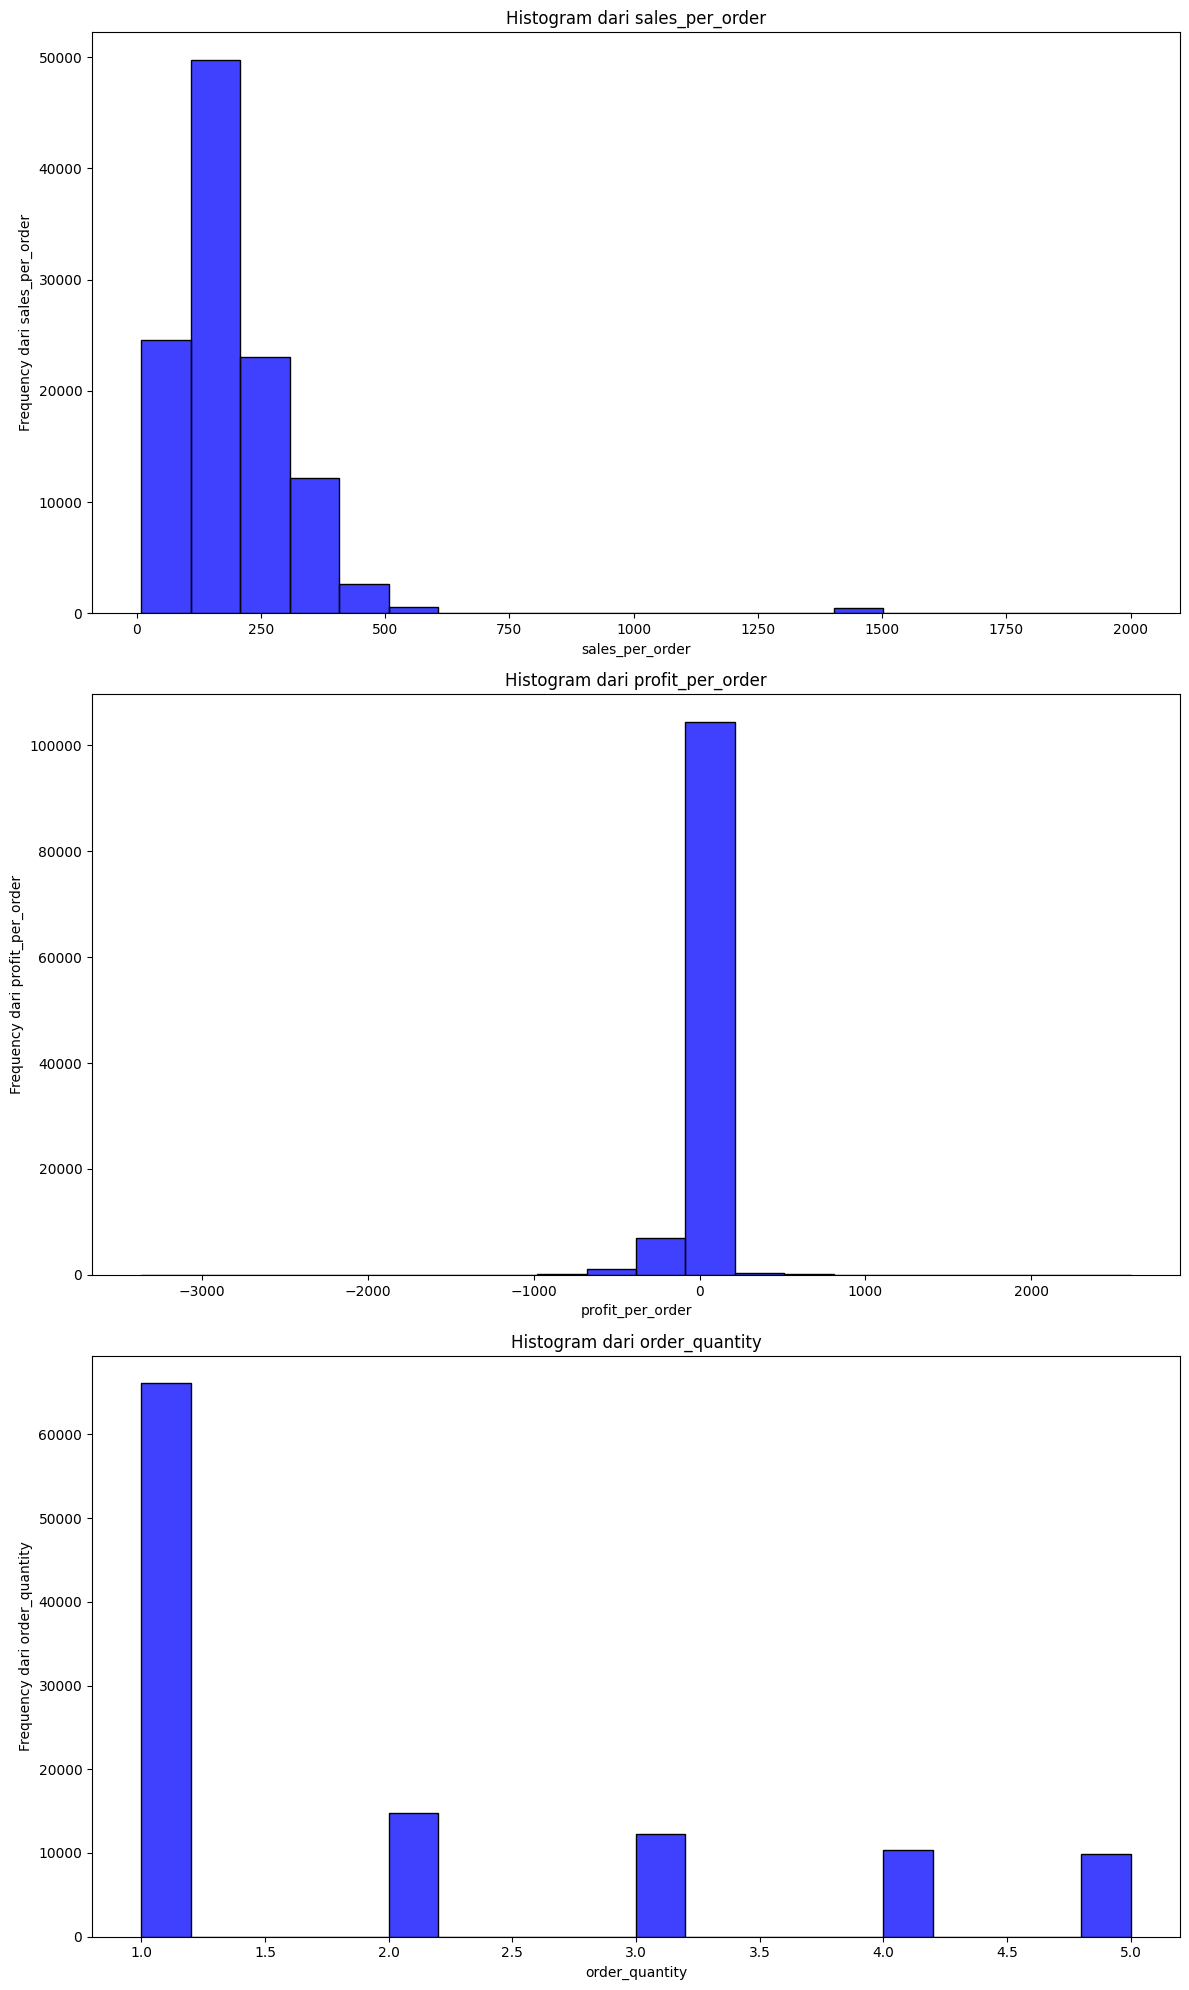

In [17]:
#Histogram
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 20))
axes = axes.flatten()

for i in range(len(nums_to_visualize)) :
  sns.histplot(ax=axes[i], x=df[nums_to_visualize[i]], bins=20, color='blue', edgecolor='black')
  axes[i].set_title(f'Histogram dari {nums_to_visualize[i]}')
  axes[i].set_ylabel(f'Frequency dari {nums_to_visualize[i]}')
  axes[i].set_xlabel(f'{nums_to_visualize[i]}')

plt.tight_layout()

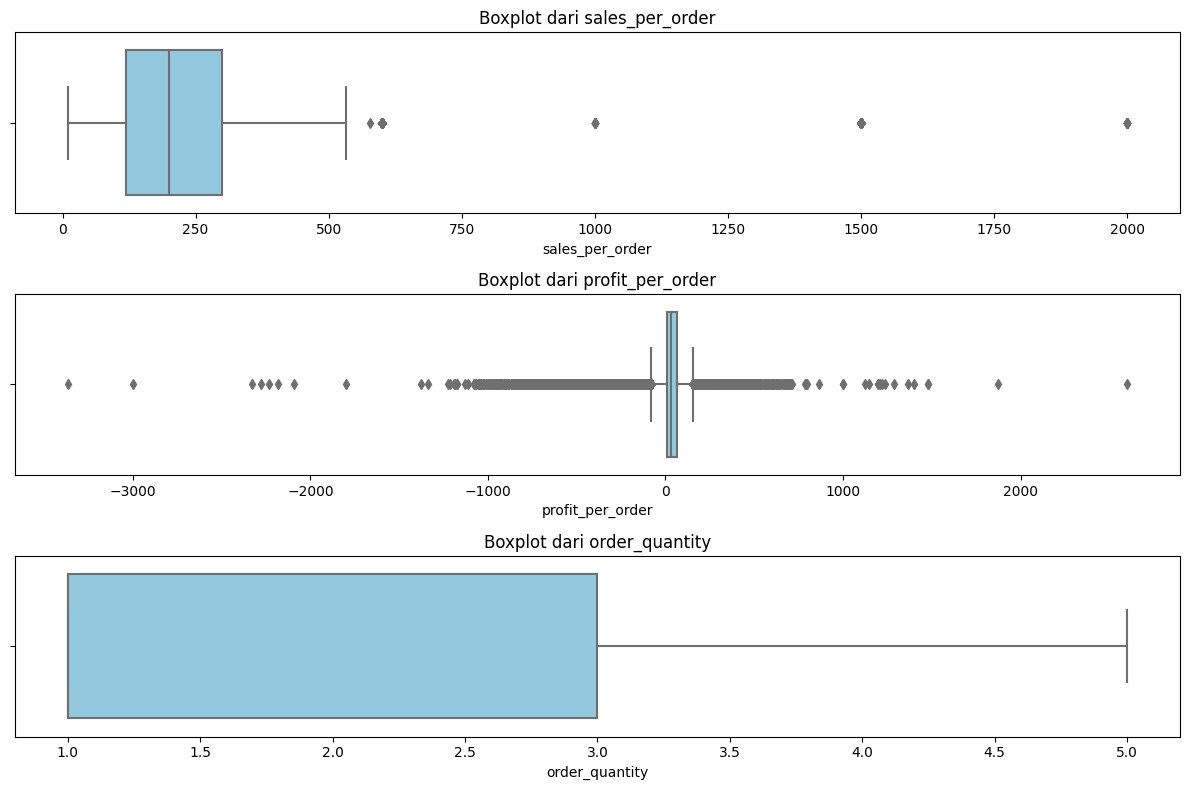

In [18]:
#Boxplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
axes = axes.flatten()

for i in range(len(nums_to_visualize)) :
  sns.boxplot(ax=axes[i], x=df[nums_to_visualize[i]], orient='h', color='skyblue')
  axes[i].set_title(f'Boxplot dari {nums_to_visualize[i]}')

plt.tight_layout()

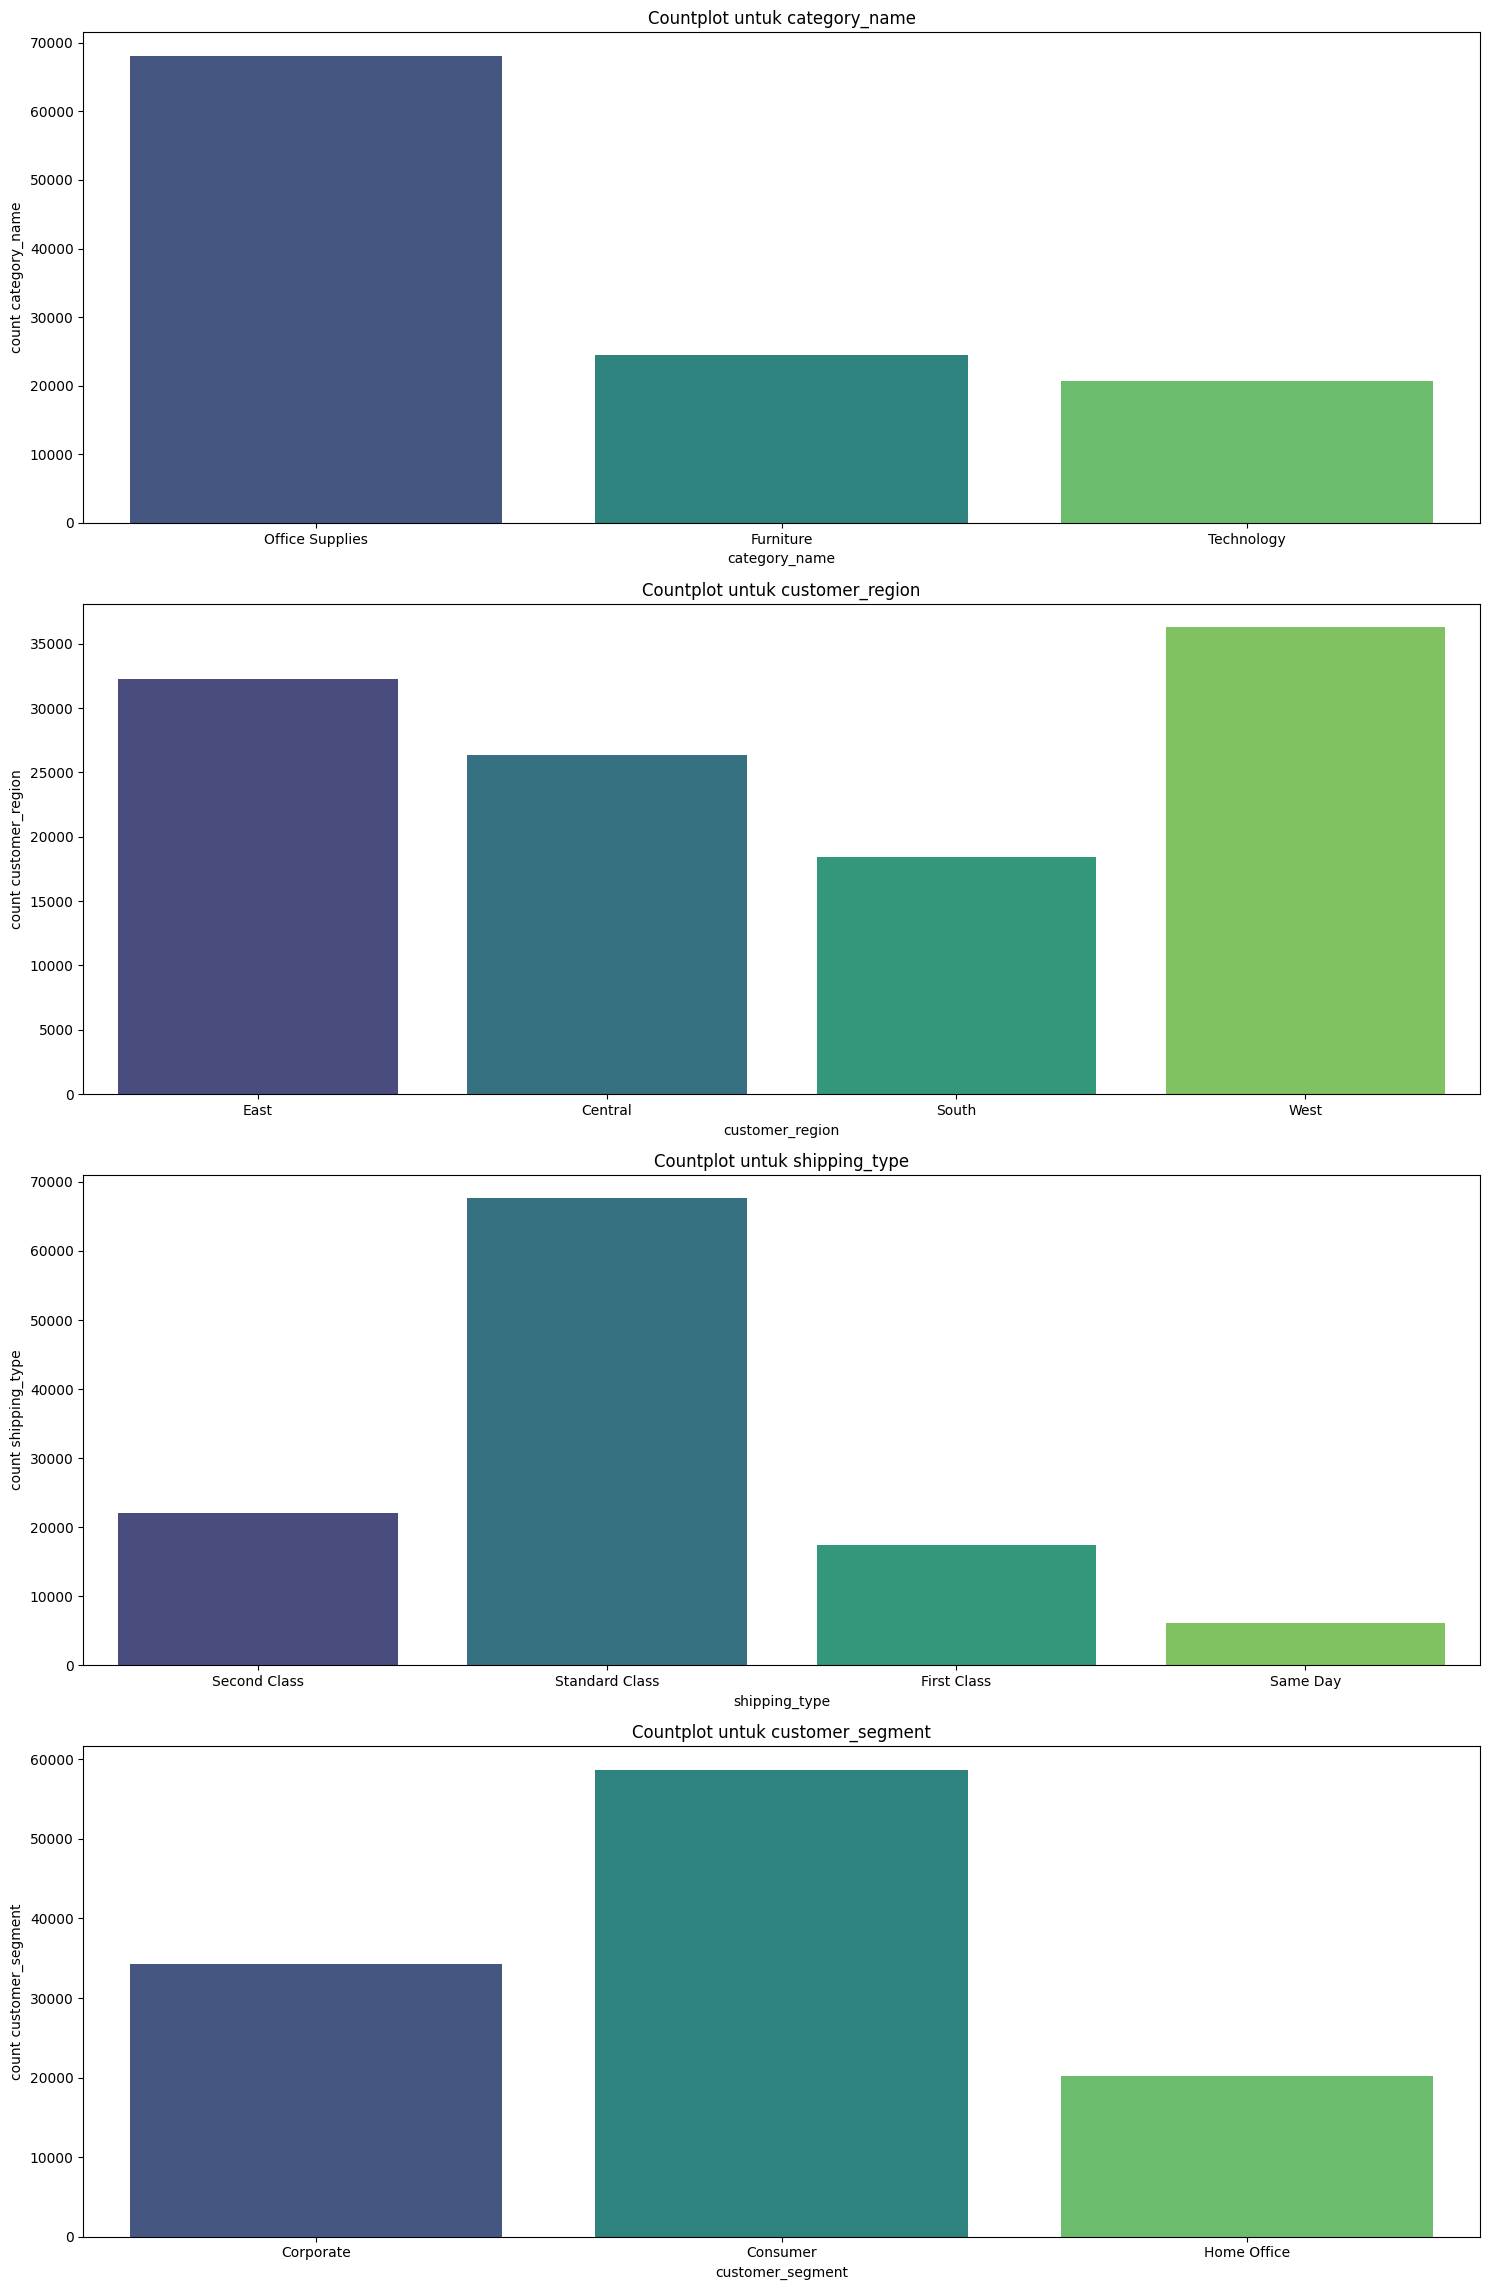

In [19]:
# Countplot Categorical
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 23))

for i in range(len(cats_to_visualize)):
    sns.countplot(data=df, x=cats_to_visualize[i], palette='viridis', ax=axes[i])
    axes[i].set_title(f'Countplot untuk {cats_to_visualize[i]}')
    axes[i].set_ylabel(f'count {cats_to_visualize[i]}')
    axes[i].tick_params(axis='x')

plt.tight_layout()
plt.show()

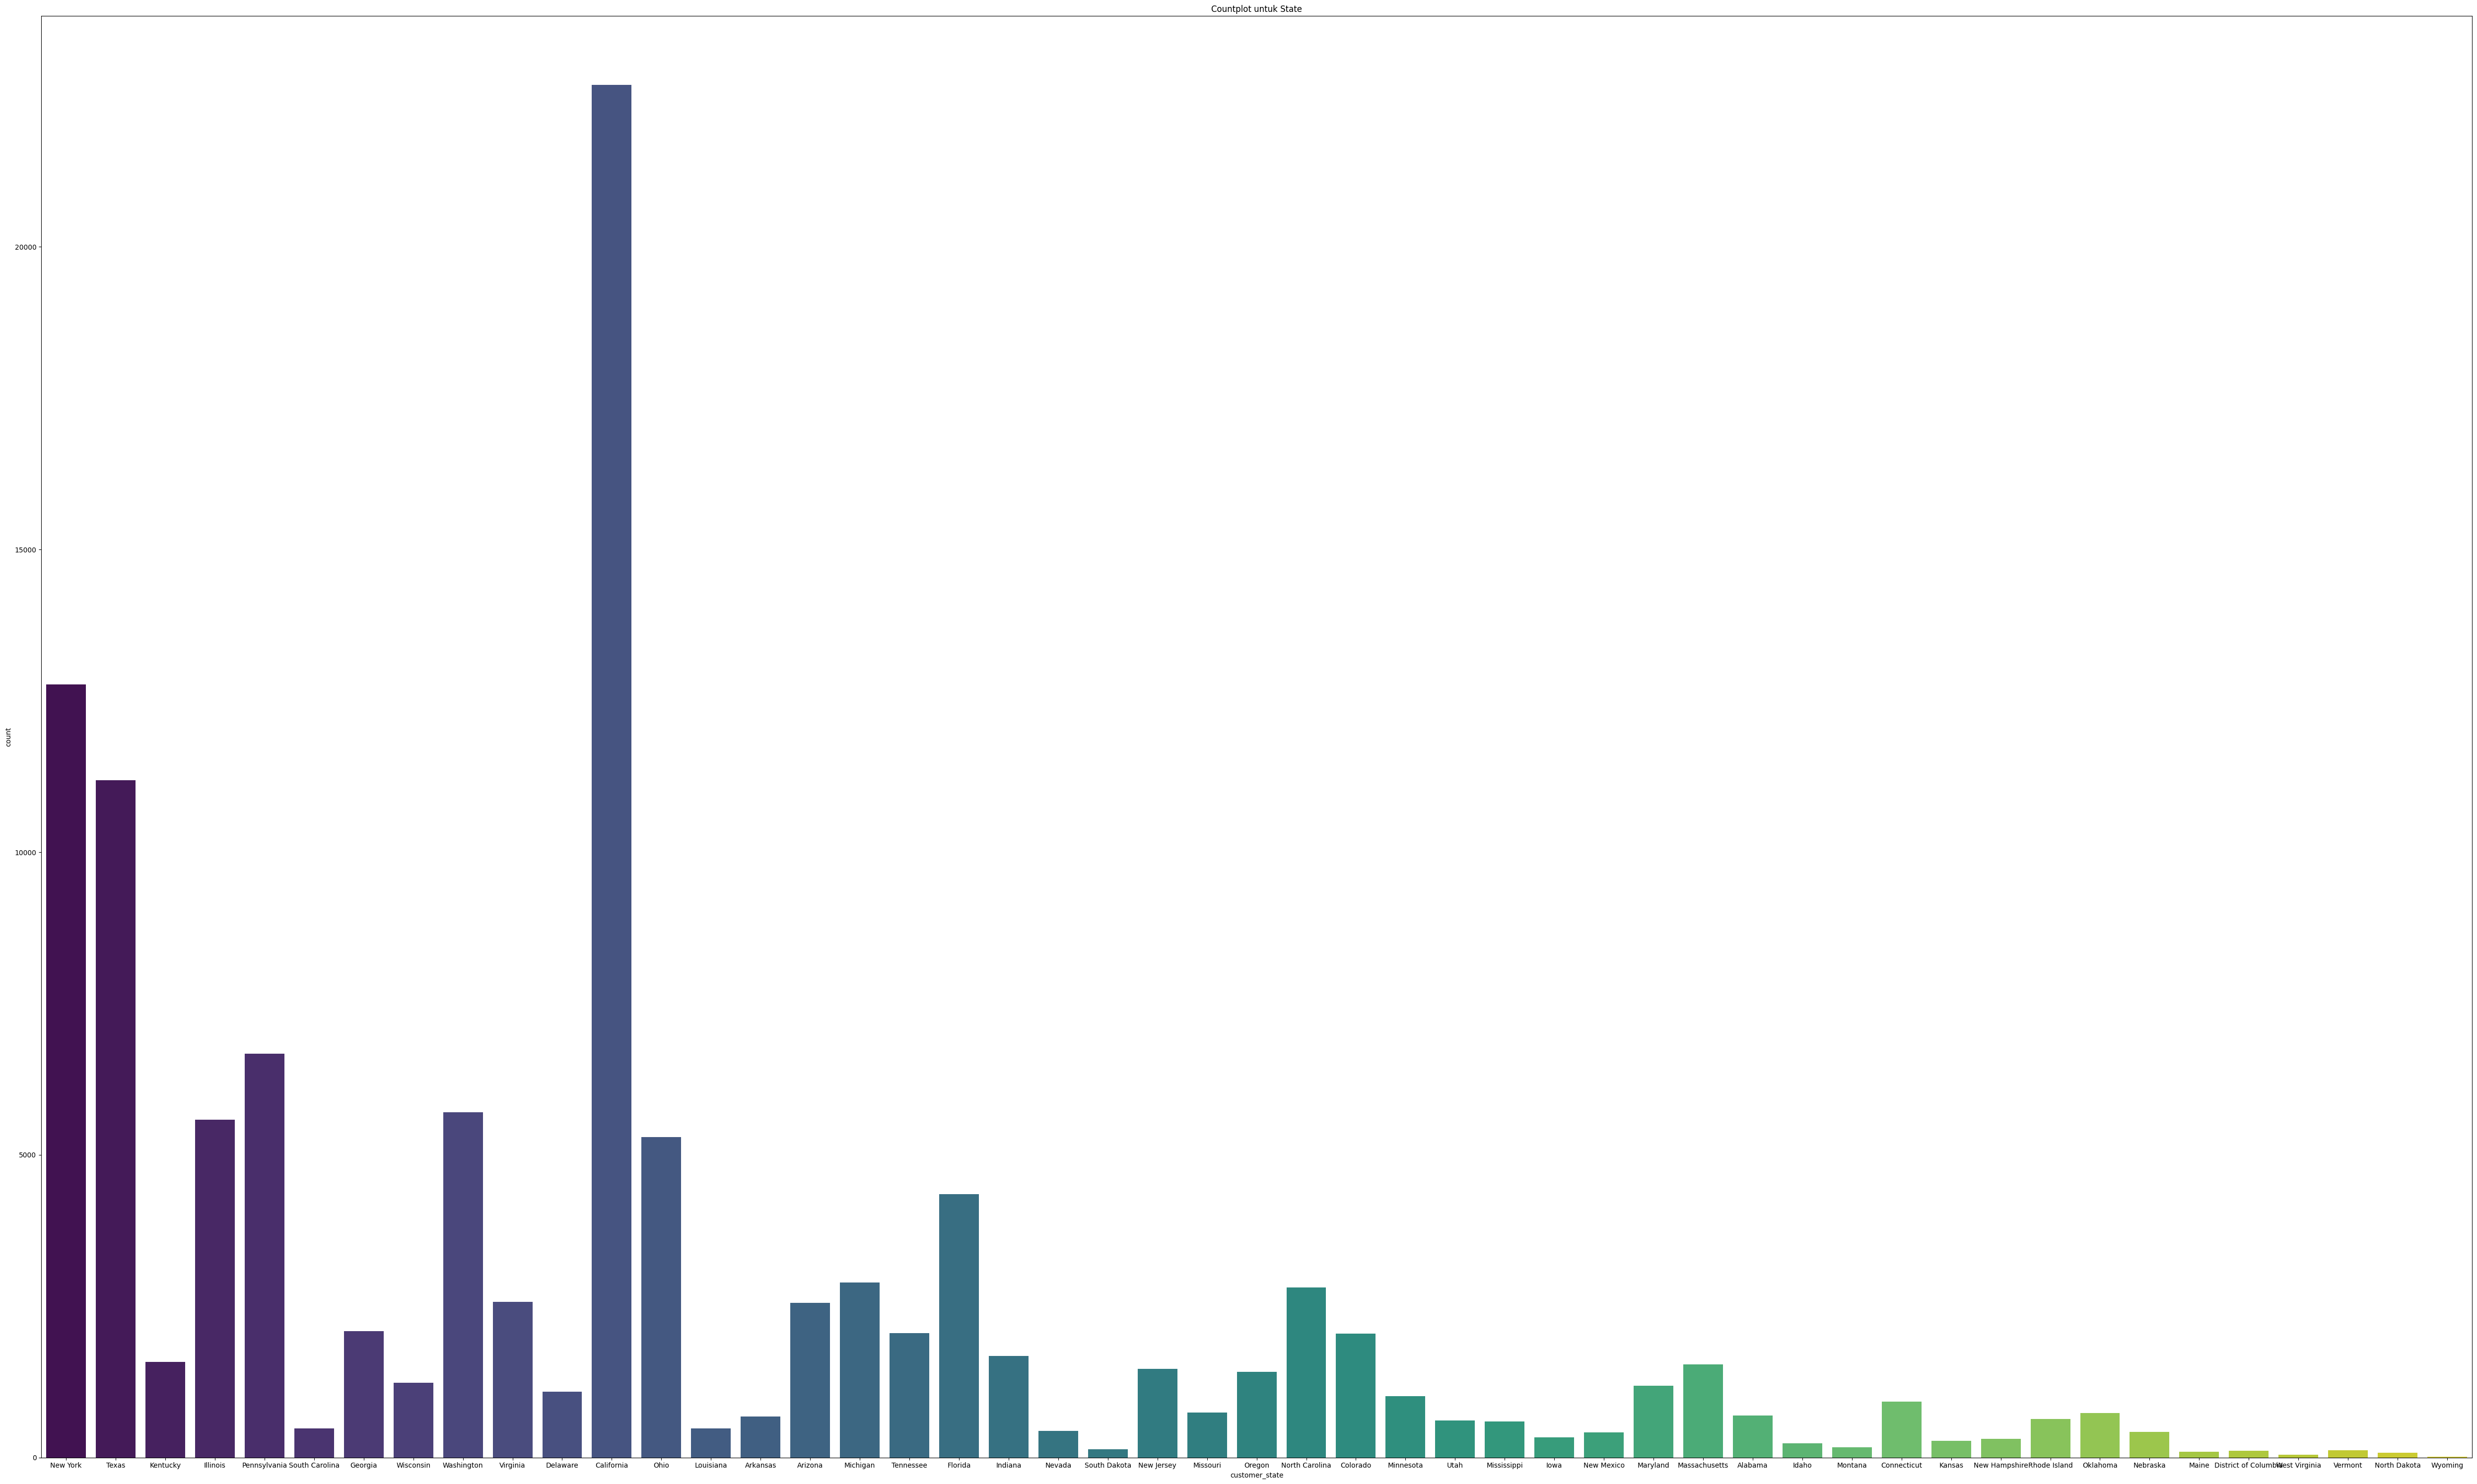

In [20]:
# Countplot Geo Categorical

plt.figure(figsize=(50,30))
sns.countplot(data=df, x='customer_state', palette='viridis')
plt.title(f'Countplot untuk State')
plt.ylabel(f'count')

plt.tight_layout()
plt.show()

# for i in range(len(geo_cats_to_visualize)):
#     sns.countplot(data=df, x=geo_cats_to_visualize[i], palette='viridis', ax=axes[i])
#     axes[i].set_title(f'Countplot untuk {geo_cats_to_visualize[i]}')
#     axes[i].set_ylabel(f'count {geo_cats_to_visualize[i]}')
#     axes[i].tick_params(axis='x')

# plt.tight_layout()
# plt.show()

In [21]:
#Export the final dataframe
df.to_csv('ecommerce_data_final.csv', index=False)

We have latitude and longitude of each state and city in a separate csv file that we will join with this dataframe in Tableau